In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
module_path = os.path.abspath(os.path.join("..", "archstyle"))
sys.path.append(module_path)


Transfer Learning for Computer Vision Tutorial
==============================================

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [2]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

cudnn.benchmark = True

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [3]:
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
categories = weights.meta["categories"]

# default transforms from pretrained model, we are not using data augmentation here
preprocess = weights.transforms()

data_transforms = {
    'train': preprocess,
    'val': preprocess,
    'test': preprocess
}

data_dir = "../data/preprocess"

batch_size = 4
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(len(class_names))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

5
Using cuda device


In [4]:
dataset_sizes

{'train': 38, 'val': 19, 'test': 38}

In [5]:
len(dataloaders["train"].dataset), len(dataloaders["val"].dataset)

(38, 19)

In [6]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }
#
#
# preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [6]:
from train import train_model

model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# model_ft.fc = nn.Linear(512, 5)


Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [8]:
model_ft, hist = train_model(model_ft, dataloaders, num_epochs=15)


Epoch 0/14
----------
train Loss: 1.7876 Acc: 0.2368
val Loss: 1.6931 Acc: 0.1053

Epoch 1/14
----------
train Loss: 1.8064 Acc: 0.2895
val Loss: 1.4326 Acc: 0.3684

Epoch 2/14
----------
train Loss: 1.0068 Acc: 0.5789
val Loss: 1.0387 Acc: 0.6842

Epoch 3/14
----------
train Loss: 0.9693 Acc: 0.6316
val Loss: 0.9451 Acc: 0.6316

Epoch 4/14
----------
train Loss: 0.4787 Acc: 0.8947
val Loss: 0.7670 Acc: 0.7895

Epoch 5/14
----------
train Loss: 0.3924 Acc: 0.9737
val Loss: 0.7478 Acc: 0.6842

Epoch 6/14
----------
train Loss: 0.4980 Acc: 0.9211
val Loss: 0.7702 Acc: 0.6842

Epoch 7/14
----------
train Loss: 0.3930 Acc: 0.9474
val Loss: 0.8062 Acc: 0.6842

Epoch 8/14
----------
train Loss: 0.4581 Acc: 0.8421
val Loss: 0.7267 Acc: 0.7368

Epoch 9/14
----------
train Loss: 0.4045 Acc: 0.8421
val Loss: 0.7662 Acc: 0.6842

Epoch 10/14
----------
train Loss: 0.2517 Acc: 0.9737
val Loss: 0.8048 Acc: 0.6842

Epoch 11/14
----------
train Loss: 0.3036 Acc: 0.9474
val Loss: 0.7843 Acc: 0.6842

Ep

In [9]:
# from dl.cv_project.archstyle.visualization import plot_hist
# plot_hist(hist)

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


Output shape: torch.Size([1, 5])
Predictions shape: torch.Size([1]) 


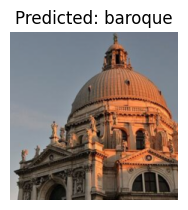

In [10]:
from visualization import visualize_model_predictions

visualize_model_predictions(
    model_ft,
    preprocess, class_names,
    img_path="../data/preprocess/test/baroque/hector_03_baroque.jpg"
)

plt.show()

Output shape: torch.Size([1, 5])
Predictions shape: torch.Size([1]) 


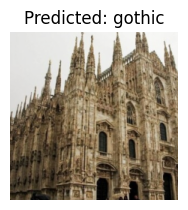

In [11]:
visualize_model_predictions(
    model_ft,
    preprocess, class_names,
    img_path="../data/preprocess/test/gothic/irina_03_gothic.jpg"
)

plt.show()

In [12]:
from train import evaluate

evaluate(model_ft, dataloaders["test"])

Accuracy: 0.8684
Total:  38
Correct:  33.0


In [13]:
evaluate(model_ft, dataloaders["train"])
evaluate(model_ft, dataloaders["val"])


Accuracy: 0.9737
Total:  38
Correct:  37.0
Accuracy: 0.7895
Total:  19
Correct:  15.0


In [14]:
# outputs = torch.tensor([[0.1, 0.3, 0.8, 0.2, 0.1],
#                         [0.9, 0.2, 0.1, 0.3, 0.05],
#                         [0.2, 0.1, 0.3, 0.7, 0.4]])
# max_values, max_indices = torch.max(outputs, dim=1)
#
# print(max_values)
# print(max_indices)

In [15]:
# def print_gpu_memory():
#     print("-" * 40)
#     print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
#     print("-" * 40)

# import gc
# del model_ft
#
# print_gpu_memory()
# torch.cuda.empty_cache()
# print_gpu_memory()
# gc.collect()
# torch.cuda.empty_cache()
# print_gpu_memory()

## we are missing optimizer here, we could pass the optimizer to train_model and release it

In [16]:
torch.save(model_ft.state_dict(), "../models/model.pth")

In [17]:
model_ft.load_state_dict(torch.load("../models/model.pth", weights_only=True))

evaluate(model_ft, dataloaders["test"])

Accuracy: 0.8684
Total:  38
Correct:  33.0
